In [84]:
import yfinance as yf
import pandas as pd
import polars as pl
import os
import re
import urllib.parse
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [85]:
COMPANY_NAME_LIST = ['Apple%2520Inc.%2520(AAPL)%2520(CIK%25200000320193)', 'MICROSOFT%2520CORP%2520(MSFT)%2520(CIK%25200000789019)', 
                     'BigCommerce%2520Holdings%252C%2520Inc.%2520(BIGC)%2520(CIK%25200001626450)', 'ROKU%252C%2520INC%2520(ROKU)%2520(CIK%25200001428439)', 
                     'JPMORGAN%2520CHASE%2520%2526%2520CO%2520(JPM%252C%2520AMJ%252C%2520AMJB%252C%2520JPM)%2520(CIK%25200000019617)', 'VISA%2520INC.%2520(V)%2520(CIK%25200001403161)', 
                     'Block%252C%2520Inc.%2520(SQ%252C%2520BSQKZ)%2520(CIK%25200001512673)', 'Robinhood%2520Markets%252C%2520Inc.%2520(HOOD)%2520(CIK%25200001783879)', 
                     'JOHNSON%252C%252C%2520JOHNSON%2520(JNJ)%2520(CIK%25200000200406)', 'PFIZER%2520INC%2520(PFE)%2520(CIK%25200000078003)', 
                     'Moderna%252C%2520Inc.%2520(MRNA)%2520(CIK%25200001682852)', 'Teladoc%2520Health%252C%2520Inc.%2520(TDOC)%2520(CIK%25200001477449)', 
                     'EXXON%2520MOBIL%2520CORP%2520(XOM)%2520(CIK%25200000034088)', 'CHEVRON%2520CORP%2520(CVX)%2520(CIK%25200000093410)', 
                     'FIRST%2520SOLAR%252C%2520INC.%2520(FSLR)%2520(CIK%25200001274494)', 'PLUG%2520POWER%2520INC%2520(PLUG)%2520(CIK%25200001093691)', 
                     'GENERAL%252CELECTRIC%2520CO%2520(GE)%2520(CIK%25200000040545)', '3M%2520CO%2520(MMM)%2520(CIK%25200000066740)', 
                     'CATERPILLAR%2520INC%2520(CAT)%2520(CIK%25200000018230)', 'FASTENAL%2520CO%2520(FAST)%2520(CIK%25200000815556)']

In [86]:
df_dict_scores = {}

for company_name in COMPANY_NAME_LIST:

    company_name_dec = urllib.parse.unquote_plus(company_name)
   
    match = re.search(r'\((.*?)\)', company_name_dec)

    if not match:
        print(f"Ticker symbol for {company_name} is not found")

    reg_output = match.group(1).split('%')
    ticker_symbol = reg_output[0]
    print(ticker_symbol)

    df_name = f"{ticker_symbol}"

    file_path_partial = os.path.join(r"C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\full_10_Q_scores", company_name)
    #print(file_path_partial)
    file_path = file_path_partial + '_f_10_Q_score_df.parquet'
    print(file_path)

    df = pl.read_parquet(file_path)

    df_dict_scores[df_name] = df

AAPL
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\full_10_Q_scores\Apple%2520Inc.%2520(AAPL)%2520(CIK%25200000320193)_f_10_Q_score_df.parquet
MSFT
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\full_10_Q_scores\MICROSOFT%2520CORP%2520(MSFT)%2520(CIK%25200000789019)_f_10_Q_score_df.parquet
BIGC
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\full_10_Q_scores\BigCommerce%2520Holdings%252C%2520Inc.%2520(BIGC)%2520(CIK%25200001626450)_f_10_Q_score_df.parquet
ROKU
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\full_10_Q_scores\ROKU%252C%2520INC%2520(ROKU)%2520(CIK%25200001428439)_f_10_Q_score_df.parquet
JPM
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\full_10_Q_scores\JPMORGAN%2520CHASE%2520%2526%2520CO%2520(JPM%252C%2520AMJ%252C%2520AMJB%252C%2520JPM)%2520(CIK%25200000019617)_f_10_Q_score_df.parquet
V
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\full_10_Q_scores\VISA%2520INC.%2520(V)%2520(CIK%25200001403161)_f_10_Q_score_df.p

In [87]:
df = df_dict_scores["AAPL"]
tic_sym = "AAPL"

This is a func that takes as an input a key-value pair from df_dict_scores and calculate 2-days, 3-days, 4-days, 5-days, 6-days, 7-days returns for it. It stores the result as a polars df with dates of starting of 4-day period as col names and corresponding returns as col values (six in each: starting from 2-days down to 7-days) - 

In [88]:
def computing_returns(tic_sym, df):

    company_ticker = yf.Ticker(tic_sym)
    hist = company_ticker.history(period="5y")
    
    four_day_returns = {}

    for date_str in df.columns:

        date = pd.Timestamp(date_str, tz='America/New_York')

        while date not in hist.index:

            date += pd.Timedelta(days=1)

        start_index = hist.index.get_loc(date)

        start_price = hist.iloc[start_index]['Open']
        end_price_list = [hist.iloc[start_index + x]['Open'] for x in range(2, 8)]
        
        retuns = []
        for end_price in end_price_list:
            ret = (end_price - start_price) / start_price * 100
            retuns.append(ret)
        

        four_day_returns[date_str] = retuns

    four_day_returns_df = pl.DataFrame(four_day_returns)
    
    return four_day_returns_df


In [89]:
computing_returns(tic_sym, df)

2019-05-01,2019-07-31,2020-01-29,2020-05-01,2020-07-31,2021-01-28,2021-04-29,2021-07-28,2022-01-28,2022-04-29,2022-07-29,2023-02-03,2023-05-05,2023-08-04,2024-02-02
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.481238,-5.031885,-1.084931,3.077714,6.072307,-4.135592,-3.246151,-0.296933,5.008753,-2.28004,-0.707022,1.763168,1.210678,-3.142532,3.891917
-2.663432,-8.515863,-6.210522,4.964194,6.310435,-2.716426,-3.868989,1.070365,5.455302,-1.340851,-0.248084,3.951915,1.193132,-2.506478,5.993553
-1.905846,-9.292136,-2.817088,5.928381,7.309107,-2.694952,-5.327191,0.69055,5.29237,1.241977,2.95832,3.88436,1.678571,-3.255721,5.298567
-3.802183,-9.707989,-0.286654,7.062837,10.228992,-2.307904,-6.287104,1.698765,3.734666,-3.460703,1.362389,1.120189,1.684493,-4.290937,5.020969
-4.516878,-7.494696,-0.579444,7.924566,9.639904,-1.408194,-3.95526,1.498513,4.44767,-4.129004,3.324911,2.128274,1.415099,-3.940107,4.892931
-5.574487,-6.633024,-0.405277,11.332862,9.026462,-2.355742,-5.012233,1.214884,3.764877,-3.763904,1.865444,2.919868,0.729863,-3.448929,3.417686


This is the general loop, that takes each key-value pair from df_dict_scores, applies computing_returns() to it, then verticaly stackes the result with orig df and stores it in the new dict

In [90]:
dict_for_anal = {}
row_names = pl.Series("row_names", ["weighted scores", "raw scores", "2_day_reterns","3_day_reterns", "4_day_reterns", "5_day_reterns", "6_day_reterns", "7_day_reterns"])

for tic_sym, df in df_dict_scores.items():

    returns_df = computing_returns(tic_sym, df)
    
    stacked_df = df.vstack(returns_df)
    stacked_df_with_indx = stacked_df.hstack([row_names])
    
    dict_for_anal[tic_sym] = stacked_df_with_indx
    

In [91]:
dict_for_anal

{'AAPL': shape: (8, 16)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ 2019-05-0 ┆ 2019-07-3 ┆ 2020-01-2 ┆ 2020-05-0 ┆ … ┆ 2023-05-0 ┆ 2023-08-0 ┆ 2024-02-0 ┆ row_name │
 │ 1         ┆ 1         ┆ 9         ┆ 1         ┆   ┆ 5         ┆ 4         ┆ 2         ┆ s        │
 │ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
 │ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ str      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ -27.26905 ┆ -27.26302 ┆ -8.944616 ┆ -9.864765 ┆ … ┆ -2.244062 ┆ -2.351985 ┆ -4.427726 ┆ weighted │
 │ 5         ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆ scores   │
 │ -129.0    ┆ -130.0    ┆ -36.0     ┆ -39.0     ┆ … ┆ -20.0     ┆ -19.0     ┆ -35.0     ┆ raw      │
 │           ┆           ┆           ┆           ┆   ┆    

Lets start the analisys. The general question is: how well sentiment scores and weighted scores can explain returns? 

Lets see them on the graph:

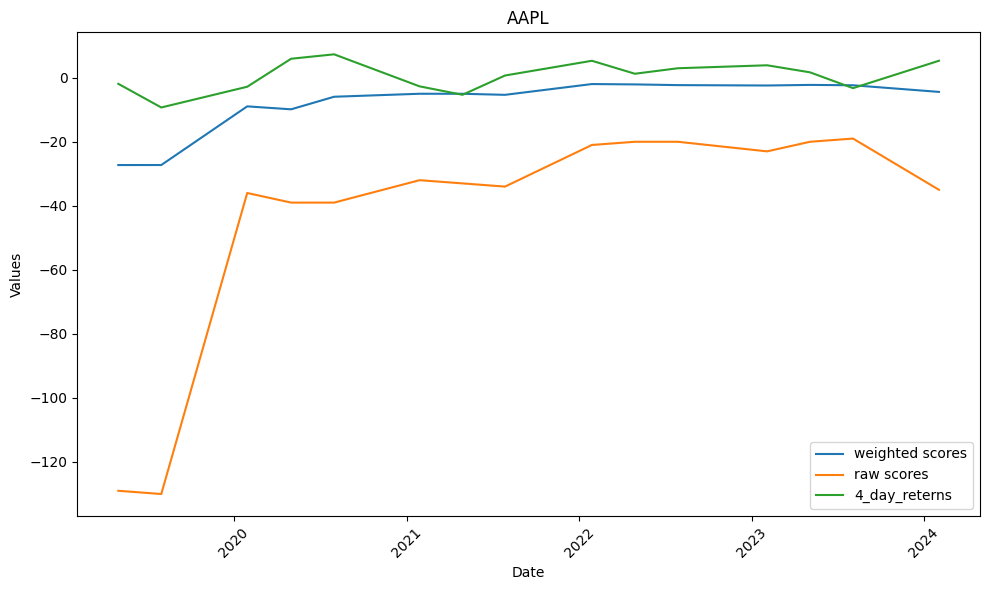

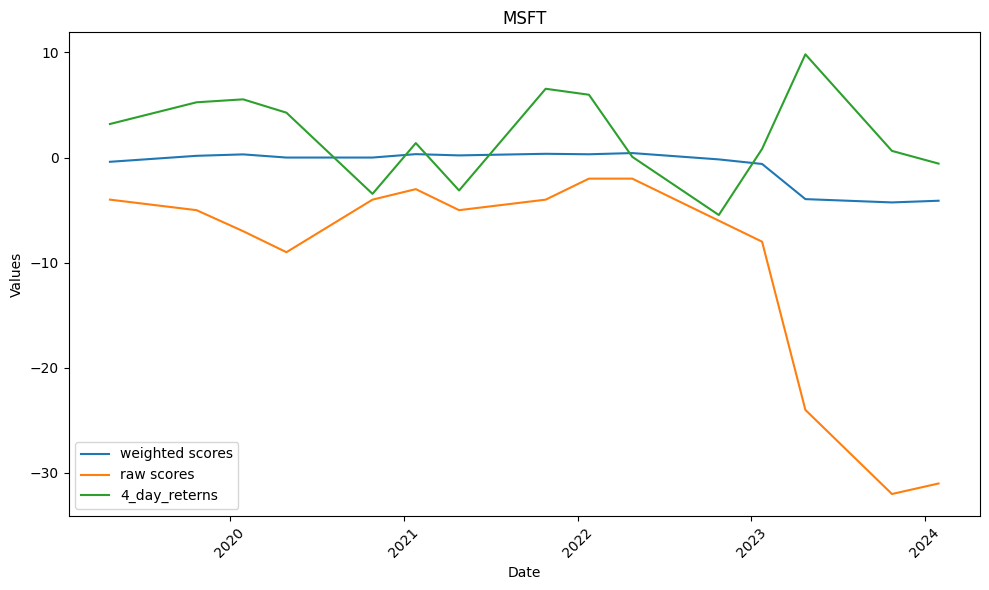

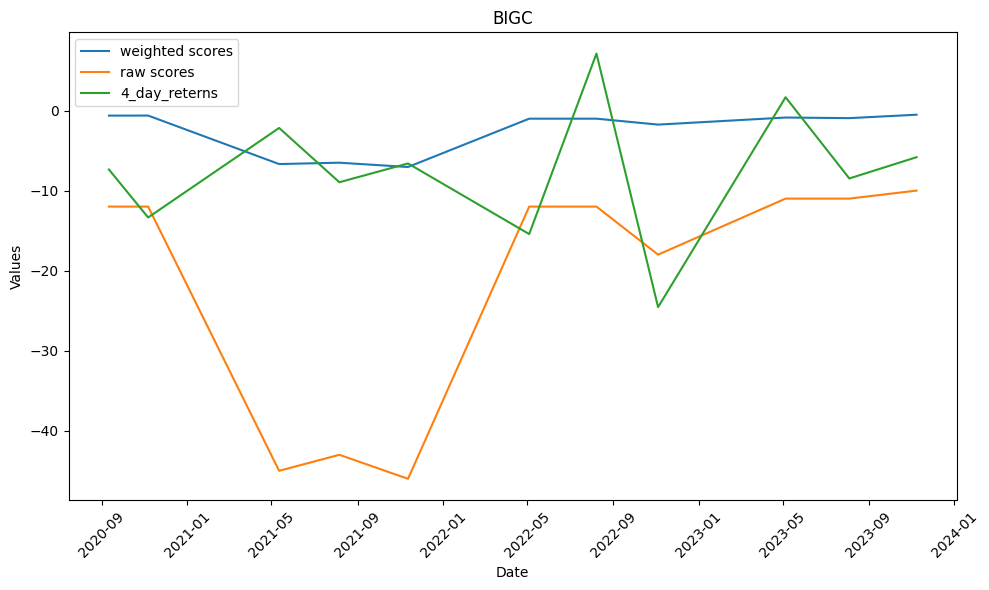

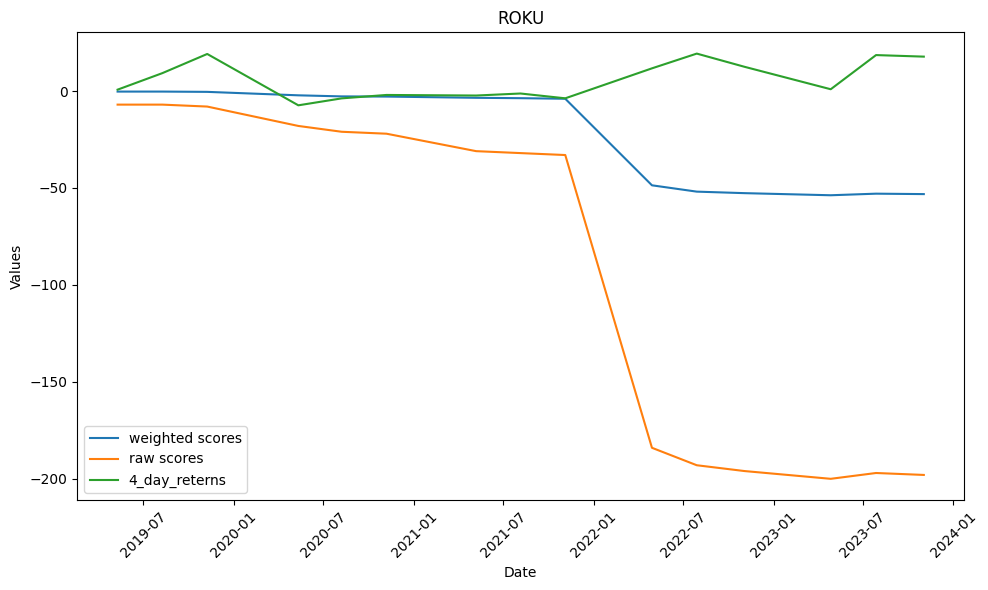

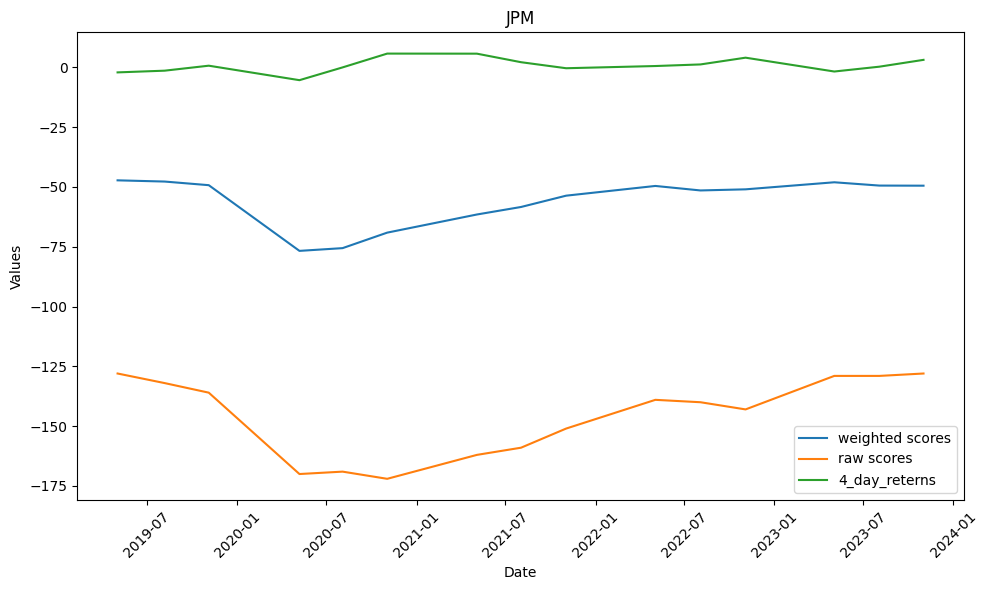

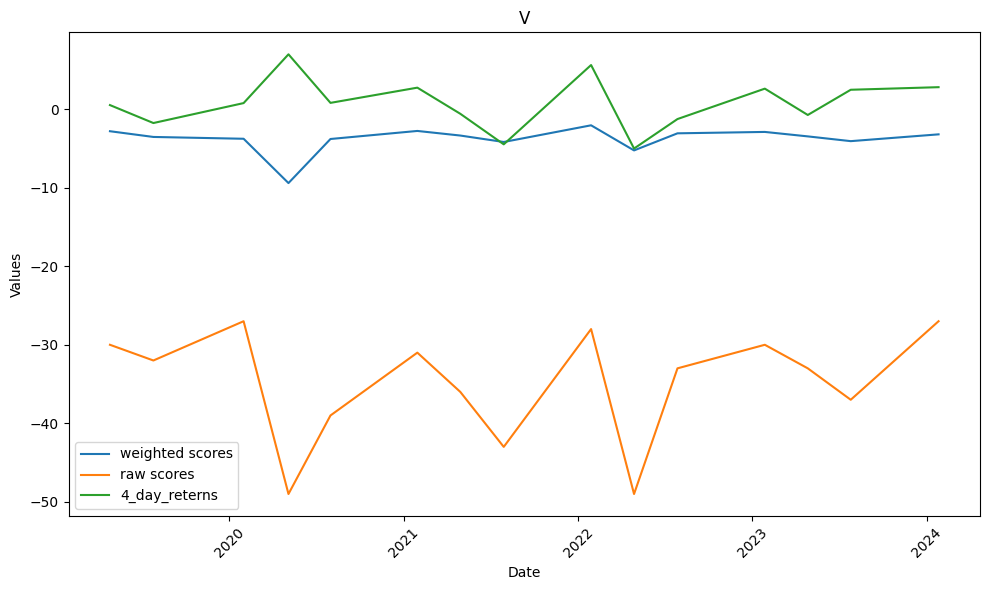

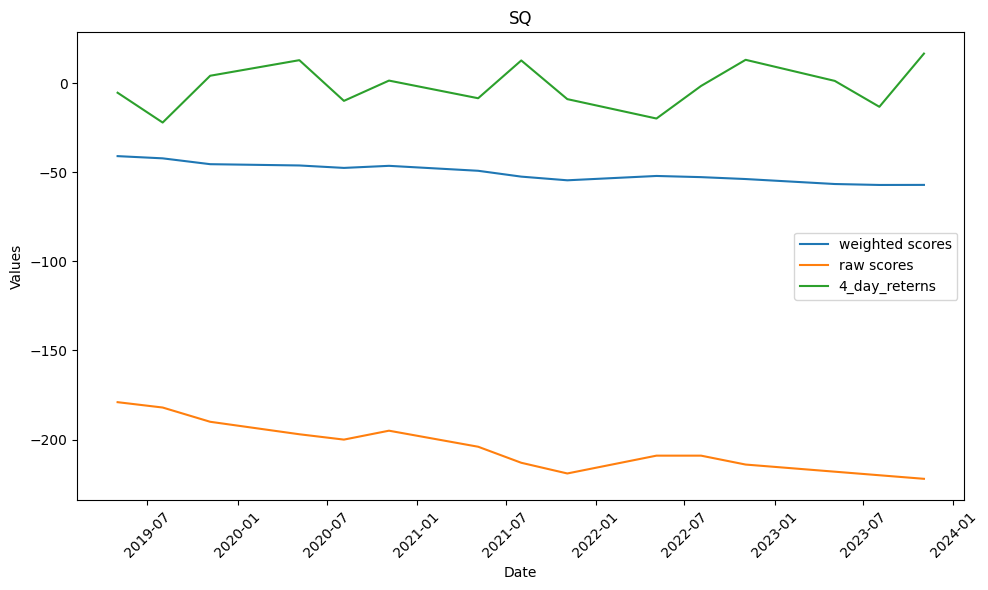

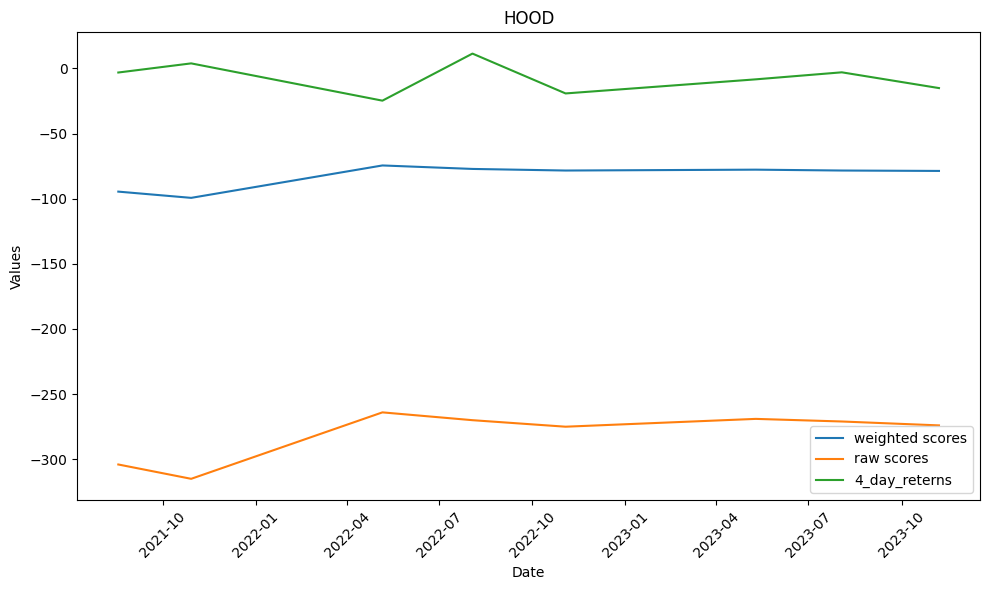

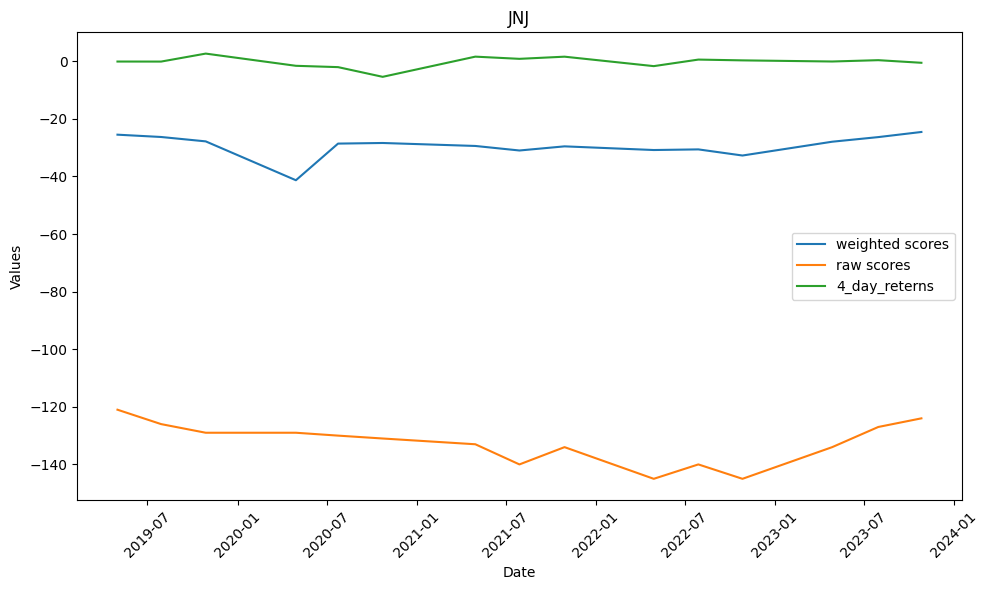

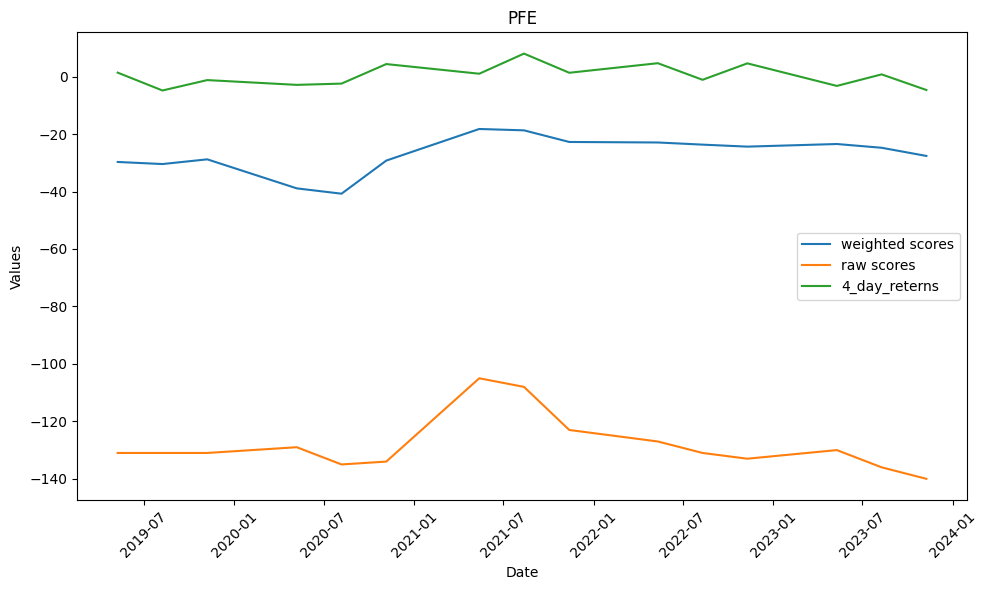

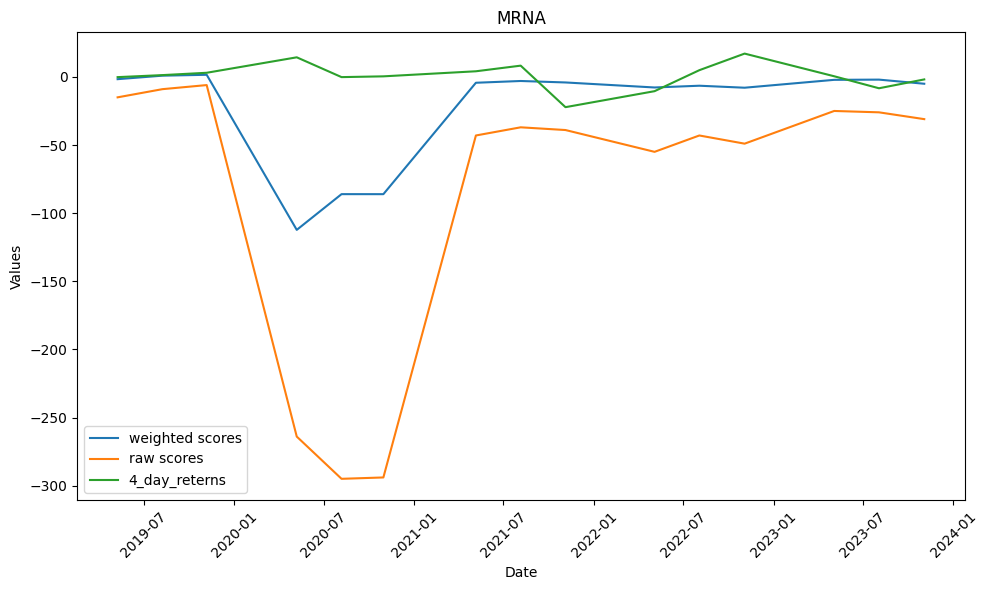

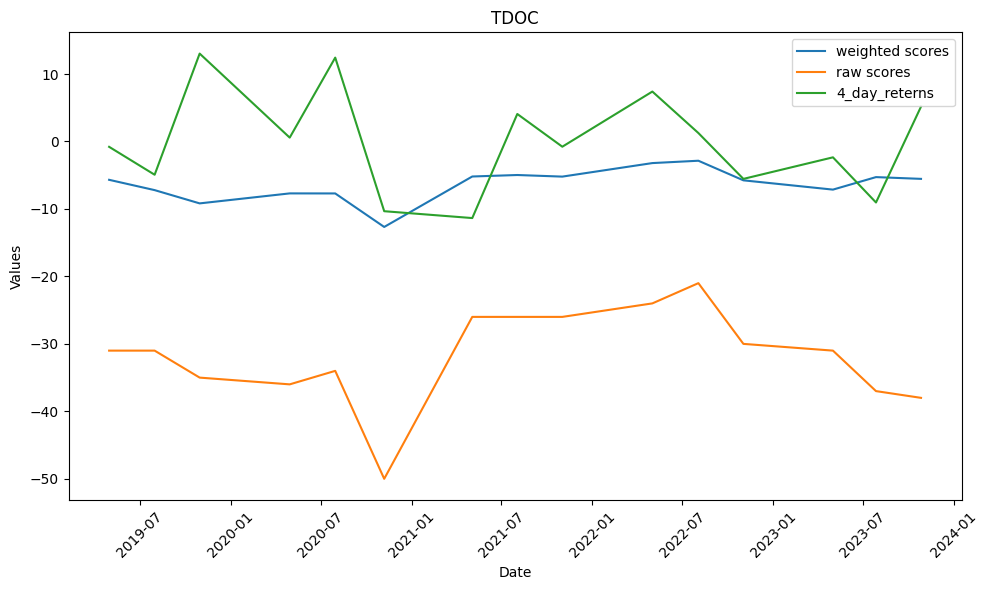

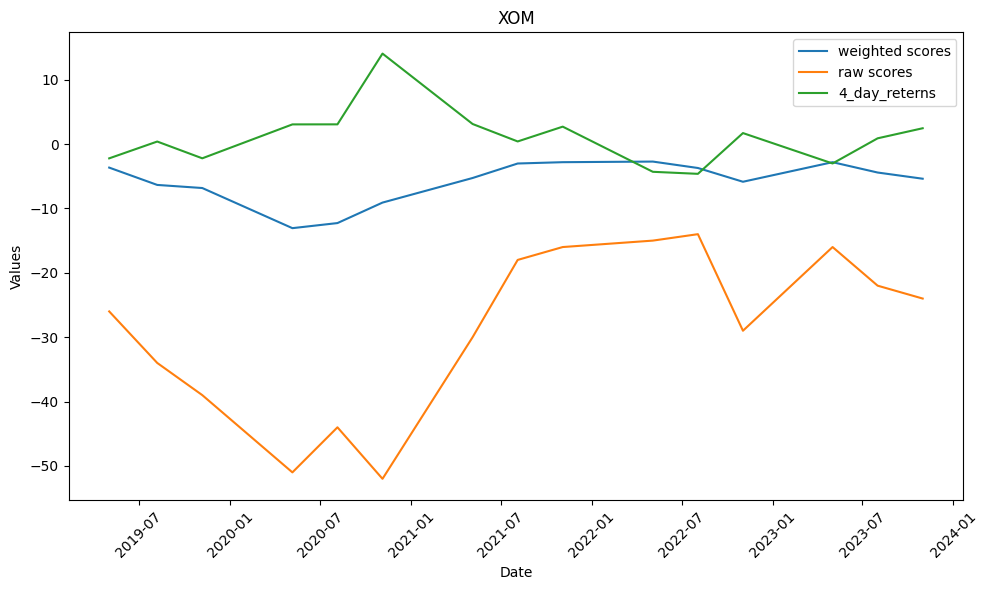

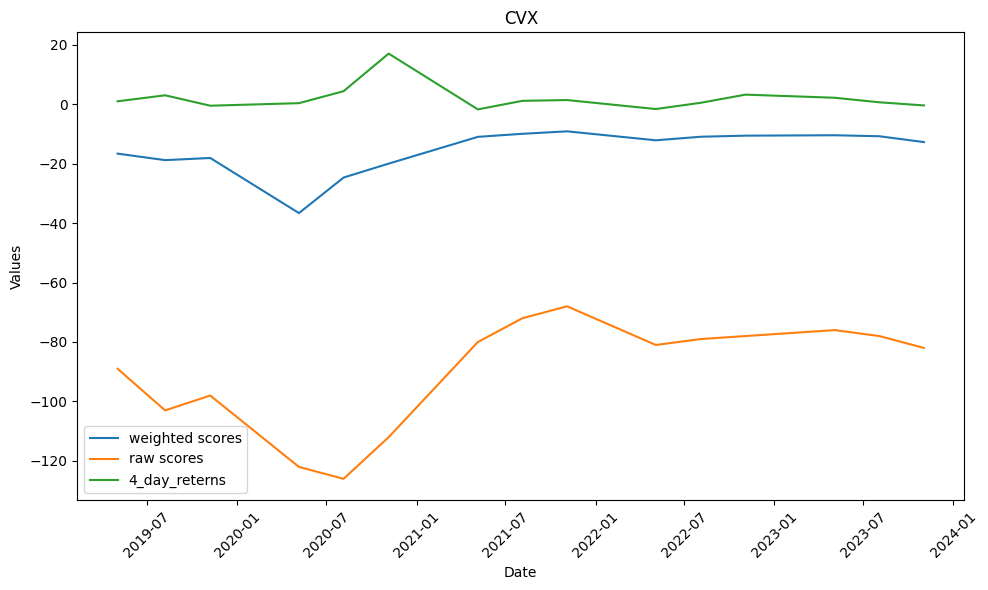

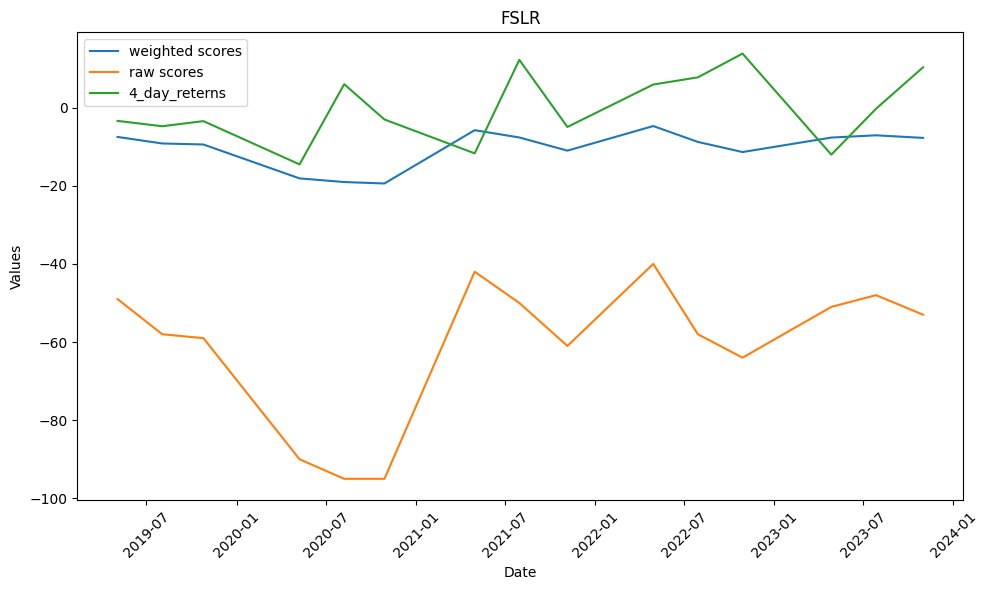

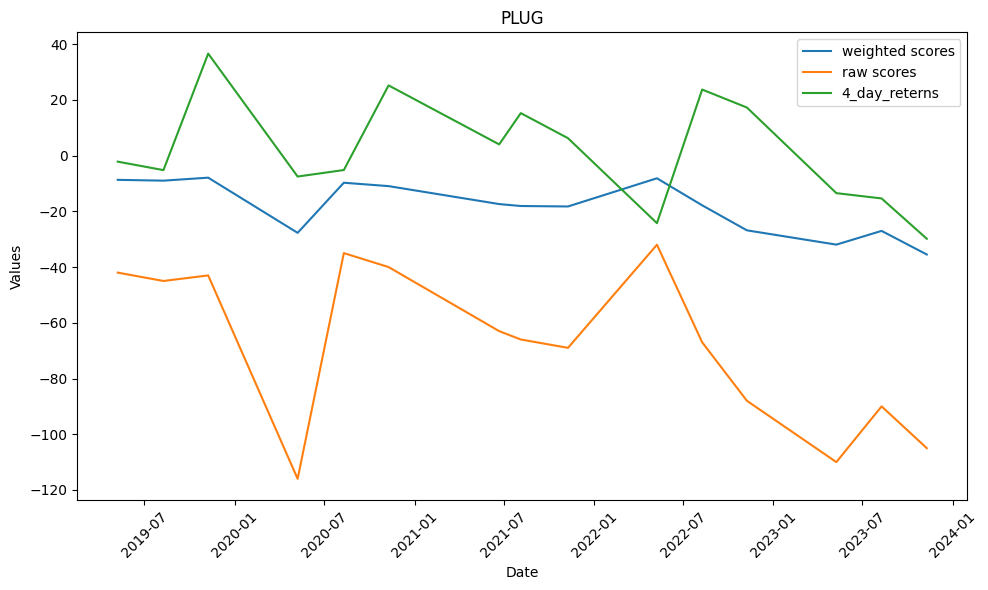

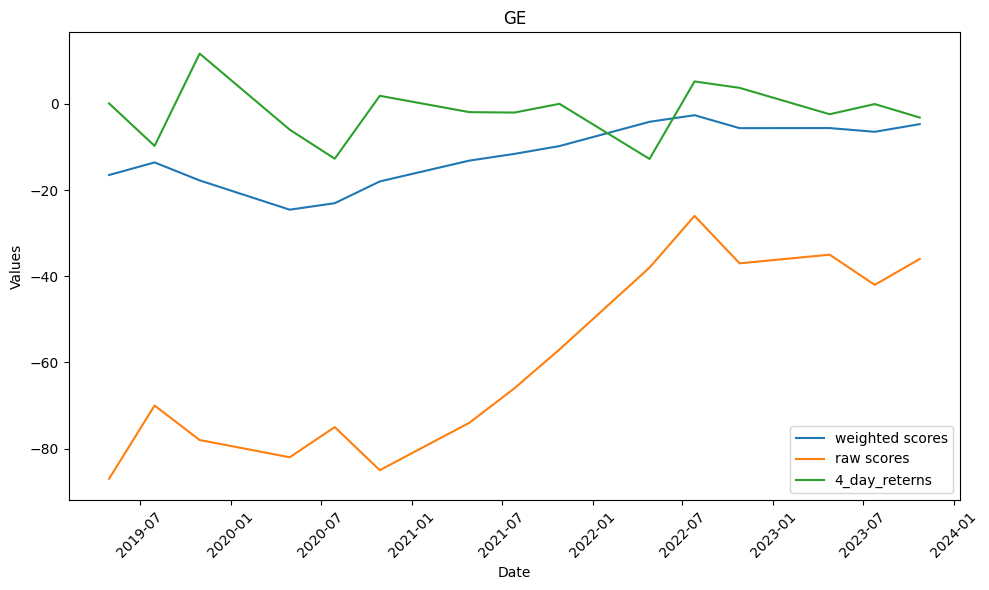

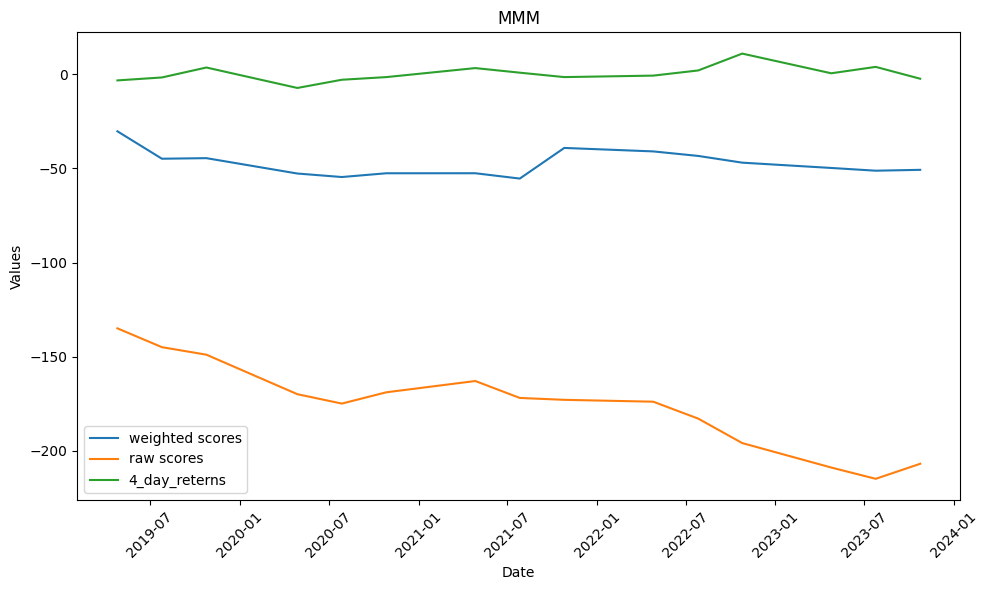

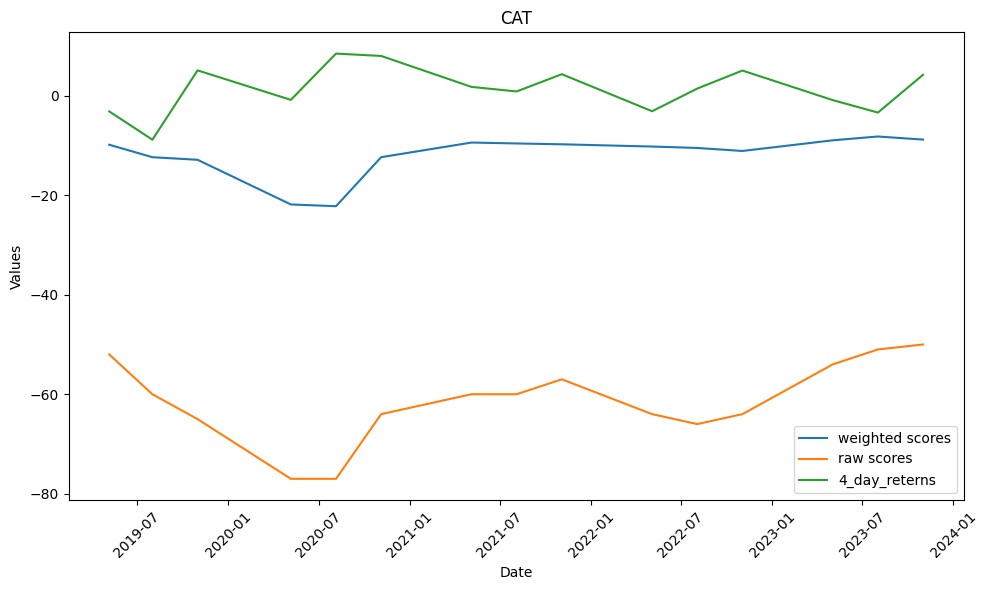

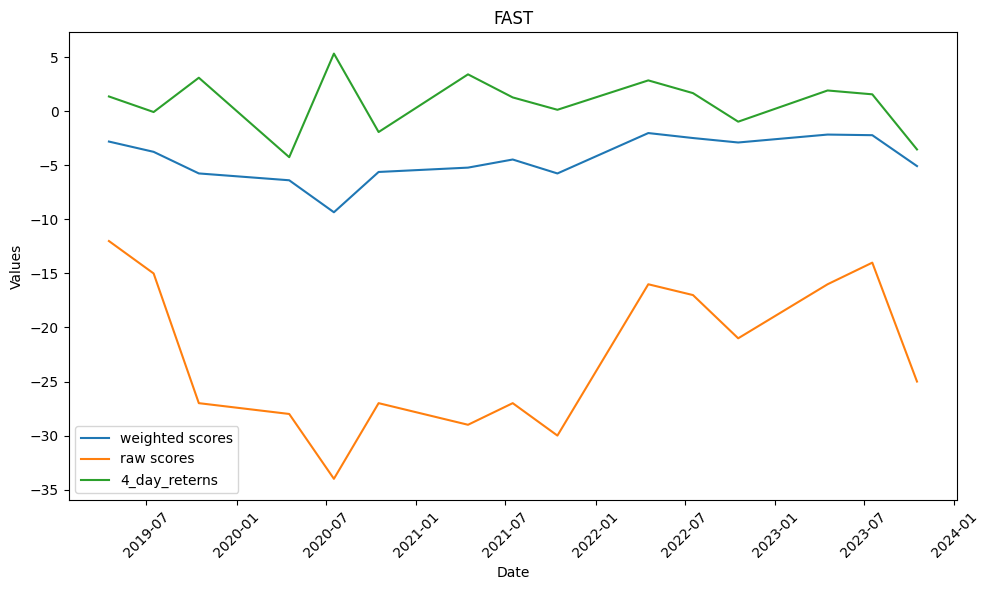

In [92]:
for company_name, scores in dict_for_anal.items():
   
    df_for_plt = scores.select(pl.exclude("row_names"))

    dates = [datetime.strptime(date, "%Y-%m-%d") for date in df_for_plt.columns]
   
    plt.figure(figsize=(10, 6))
    row_indices_to_plot = [0, 1, 4]

    for idx in row_indices_to_plot:
        row = df_for_plt.row(idx, named=True)  
        plt.plot(dates, list(row.values()), label=scores.row(idx)[-1])

    plt.title(company_name)
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

At first glance some time series exhibits at least piecewise dependence. 

Next step is to regress each return on weighted and raw scores.

This func takes as input key-value pair (company name and dataframe with sentiment scores and returns), regress each retern (2_days, 3_days, etc) on weightes sentiment score ans raw sentiment score. Then it collects the slopes (beta-coefficient) of returns regressed on raw score and on weighted score in the separate polars series (in the loop they will be staked in dataframe)

In [93]:
def regression_slopes(company_df, company_name):

    # x_1 - weighted score
    # x_2 - raw score
    company_df_woi = company_df.select(pl.exclude("row_names"))
    x_1 = company_df_woi.row(0)
    x_2 = company_df_woi.row(1)

    x_1 = sm.add_constant(x_1)
    x_2 = sm.add_constant(x_2)
    
    Y = [company_df_woi.row(y) for y in range(2, 8)]
         
    slopes_weighted = []
    for y in Y:
        
        model = sm.OLS(y, x_1).fit()
        slope = model.params[1]
        slopes_weighted.append(slope)
    
    slopes_raw = []
    for y in Y:
        
        model = sm.OLS(y, x_2).fit()
        slope = model.params[1]
        slopes_raw.append(slope)

    slopes_weighted = pl.Series(company_name, slopes_weighted)
    slopes_raw = pl.Series(company_name, slopes_raw)

    return slopes_weighted, slopes_raw

This is the general loop that takes dict_for_anal() whith scores and returns and for each company in the dict it calculates two series: first one contain regression slopes for weighted scores and second one for raw scores. Serieses stacked in the separete dataframes (for raw and for weighted scores)

In [94]:
def compute_all_slopes(dict_for_anal):

    weighted_slopes_df = pl.DataFrame()
    raw_slopes_df = pl.DataFrame()
    
    for company_name, company_df in dict_for_anal.items(): 
        slopes_weighted, slopes_raw = regression_slopes(company_df, company_name)
        
        weighted_slopes_df = weighted_slopes_df.hstack([slopes_weighted])
        raw_slopes_df = raw_slopes_df.hstack([slopes_raw])
        
    return weighted_slopes_df, raw_slopes_df
        

In [95]:
weighted_slopes_df, raw_slopes_df = compute_all_slopes(dict_for_anal)

As an output from previous functions we have two dataframes with regression slopes of different returns on raw and on weighted scores. Each col of these dfs contain regression slopes for particular company. First row contain slope for 2_days return, second row contain slope for 3_days return, etc.  I have decided to check what is the proportion of positive regression slopes for each return timeframe (2_days, 3_days, etc). For that purpose i will transpose each of these dfs, apply condition > 0, then verticaly sum boolean values and obtain the prorortion of positive slopes for each time frame. 

In [96]:
def calc_efficiency_metrics(slopes_df):

    df_tranposed = slopes_df.transpose()

    res = df_tranposed.select(pl.all() > 0).sum()
    total_num_of_slopes = slopes_df.shape[1]

    positive_slopes = [res.select(pl.col(res.columns[x]).gather(0)).item() for x in range(slopes_df.shape[0])]

    for counter, x in enumerate(positive_slopes):
        print(f'Prorortion of positive {counter + 2}_day returns: {x/total_num_of_slopes}')
    
    

    

In [97]:
calc_efficiency_metrics(raw_slopes_df)

Prorortion of positive 2_day returns: 0.55
Prorortion of positive 3_day returns: 0.45
Prorortion of positive 4_day returns: 0.4
Prorortion of positive 5_day returns: 0.45
Prorortion of positive 6_day returns: 0.4
Prorortion of positive 7_day returns: 0.4


In [99]:
calc_efficiency_metrics(weighted_slopes_df)

Prorortion of positive 2_day returns: 0.6
Prorortion of positive 3_day returns: 0.45
Prorortion of positive 4_day returns: 0.4
Prorortion of positive 5_day returns: 0.35
Prorortion of positive 6_day returns: 0.5
Prorortion of positive 7_day returns: 0.5


Positive slopes means that sentiment scores and returns mooves in the same direction (hense, they are working as predictors of stock price movement). As the result of this preliminary analisis we can say that sentiment scores of 10-Q reports are not very good predictors of stock movments. Positive proportion of this slopes are close to 0.5, which means that on average in our sample there are 50/50 chance that scores and returns are mooving in the same direction.

As we can see that, despite visual conclusion that weighted scores are more "smooth", they barely outperform raw scores, but at least they are not worse, meaning that at each time frame the proportion of positive regression slopes of weighted scores => proportion of positive regression slopes of raw scores.